<a href="https://colab.research.google.com/github/saracherif123/Bachelor-Thesis-Project/blob/main/MultilayerPerceptron_datesets_subject_main_match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MultilayerPerceptron datesets_subject_main_match (Rel Model)**


## Spark Confirguration in Google Colab






In [1]:
!ls

all_topics_datasets_matching.csv  spark-3.1.1-bin-hadoop3.2.tgz.1
spark-3.1.1-bin-hadoop3.2	  spark-3.1.1-bin-hadoop3.2.tgz.2
spark-3.1.1-bin-hadoop3.2.tgz


In [2]:
!pwd

/content


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

### Import necessary libraries

In [6]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler


### Load Dataset

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering using K-Means").getOrCreate()
data = spark.read.csv("all_topics_datasets_matching.csv", header=True, inferSchema=True)
data.show(10)



+----+----+-------------+--------------------+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+
|did1|did2|dataset_name1|       dataset_name2|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_m

In [8]:
data.printSchema()

root
 |-- did1: integer (nullable = true)
 |-- did2: integer (nullable = true)
 |-- dataset_name1: string (nullable = true)
 |-- dataset_name2: string (nullable = true)
 |-- num_instances: double (nullable = true)
 |-- num_attributes: double (nullable = true)
 |-- dimensionality: double (nullable = true)
 |-- num_numeric_attr: double (nullable = true)
 |-- pct_numeric_attr: double (nullable = true)
 |-- num_nominal_attr: double (nullable = true)
 |-- pct_nominal_attr: double (nullable = true)
 |-- avg_nominal_values: double (nullable = true)
 |-- sd_nominal_values: double (nullable = true)
 |-- min_nominal_values: double (nullable = true)
 |-- max_nominal_values: double (nullable = true)
 |-- avg_numeric_mean: double (nullable = true)
 |-- sd_numeric_mean: double (nullable = true)
 |-- min_numeric_mean: double (nullable = true)
 |-- max_numeric_mean: double (nullable = true)
 |-- missing_attr_cnt: double (nullable = true)
 |-- missing_attr_pct: double (nullable = true)
 |-- missing_ins

In [9]:
data=data.drop("did1","did2","dataset_name1","dataset_name2")
data

num_instances,num_attributes,dimensionality,num_numeric_attr,pct_numeric_attr,num_nominal_attr,pct_nominal_attr,avg_nominal_values,sd_nominal_values,min_nominal_values,max_nominal_values,avg_numeric_mean,sd_numeric_mean,min_numeric_mean,max_numeric_mean,missing_attr_cnt,missing_attr_pct,missing_instances_max_cnt,missing_instances_max_pct,missing_instances_min_cnt,missing_instances_min_pct,missing_instances_mean,missing_instances_mean_pct,datesets_subject_main_match,datesets_duplicates_match
0.747015,0.0,0.747015,1.0,1.0,0.833333,0.833333,0.992834,0.993118,0.333333,0.984317,1.0,1.0,0.0,1.0,0.8,0.8,0.870968,0.967357,0.95,0.80236,0.911111,0.977512,0,0
0.996786,0.976654,0.862327,1.0,1.0,0.666667,0.992218,0.870246,0.838809,0.0,0.671875,1.0,1.0,1.0,1.0,0.990476,0.592063,0.99177,0.60947,0.0,0.996786,0.987738,0.73788,0,0
0.843658,0.333333,0.765487,1.0,1.0,0.944444,0.916667,0.939203,1.0,0.962264,0.603774,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.0678466,0.333333,0.28481,1.0,1.0,0.833333,0.75,0.0333333,0.891071,0.333333,0.809524,1.0,1.0,1.0,1.0,0.375,0.583333,0.851613,0.840813,0.5,0.533923,0.626667,0.599494,0,0
0.823009,0.0555556,0.812598,1.0,1.0,0.166667,0.117647,0.121212,0.838432,0.333333,0.761905,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.987917,0.611111,0.995301,1.0,1.0,0.777778,0.428571,0.660819,0.163264,0.5,0.142857,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.951703,0.704918,0.836325,0.0,0.0,0.704918,0.0,0.934284,0.954003,0.5,0.956967,0.0,0.0,0.0,0.0,0.722222,0.0586419,0.975303,0.488643,0.992593,0.84663,0.984144,0.671701,0,0
0.0678466,0.333333,0.28481,1.0,1.0,0.833333,0.75,0.0333333,0.891071,0.333333,0.809524,1.0,1.0,1.0,1.0,0.375,0.583333,0.851613,0.840813,0.5,0.533923,0.626667,0.599494,0,0
0.687316,0.444444,0.437168,1.0,1.0,0.944444,0.9,0.462963,1.0,0.666667,0.714286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
0.999669,0.388889,0.999798,1.0,1.0,0.944444,0.909091,0.677778,1.0,0.8,0.52381,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0


## Data Preprocessing

In [10]:
# Create vector assembler
from pyspark.ml.feature import VectorAssembler
labelCol = 'datesets_subject_main_match'
numericCols = ['num_instances','num_attributes',
 'dimensionality','num_numeric_attr','pct_numeric_attr','num_nominal_attr', 'pct_nominal_attr',
 'avg_nominal_values','sd_nominal_values','min_nominal_values','max_nominal_values','avg_numeric_mean',
 'sd_numeric_mean','min_numeric_mean','max_numeric_mean','missing_attr_cnt','missing_attr_pct',
 'missing_instances_max_cnt','missing_instances_max_pct','missing_instances_min_cnt','missing_instances_min_pct',
 'missing_instances_mean','missing_instances_mean_pct']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")


# Transform the training data
data = assembler.transform(data)






### Cluster-based Undersampling



In [11]:
# Filter the data where `datesets_subject_main_match` is equal to zero
filtered_data_0 = data.filter(col("datesets_subject_main_match") == 0)

# Show the filtered data
filtered_data_0.show()



+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_main_match|datesets_d

In [12]:
# Filter the data where `datesets_subject_main_match` is equal to one
filtered_data_1 = data.filter(col("datesets_subject_main_match") == 1)

# Show the filtered data
filtered_data_1.show()


+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_main_match|datesets_d

In [13]:
#Standard scaling the filtered datasets
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(filtered_data_0)
data_scale_output_0=data_scale.transform(filtered_data_0)
data_scale_output_0.show(2)

+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_

In [14]:
#Standard scaling the filtered datasets
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(filtered_data_1)
data_scale_output_1=data_scale.transform(filtered_data_1)
data_scale_output_1.show(2)

+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datesets_subject_

## Clustering Dataset Using Kmeans
Choice of K based on Elbow Method

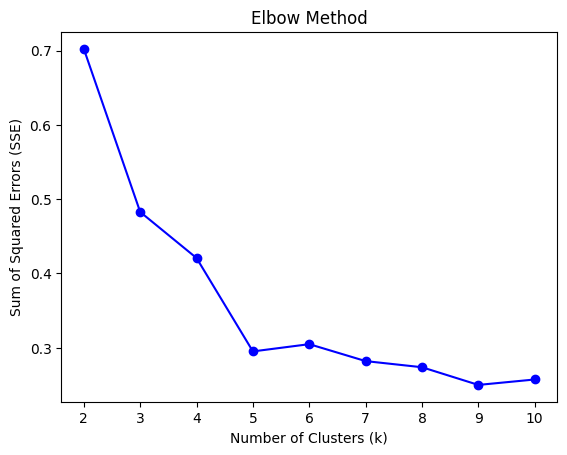

In [15]:
# Create an empty list to store the SSE (Sum of Squared Errors) values
sse = []

# Define the range of cluster numbers to evaluate
k_values = range(2, 11)  # Range from 2 to 10 clusters

# Iterate over each cluster number
for k in k_values:
    # Create a KMeans instance with the current cluster number
    kmeans = KMeans(featuresCol='standardized', k=k)
    
    # Fit the KMeans model to the data
    model = kmeans.fit(data_scale_output_0)
    
    # Make predictions on the data
    predictions = model.transform(data_scale_output_0)
    
    # Evaluate the clustering performance using the SSE metric
    evaluator = ClusteringEvaluator()
    sse_value = evaluator.evaluate(predictions)
    sse.append(sse_value)

# Plot the SSE values against the number of clusters
plt.plot(k_values, sse, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method')
plt.show()




## Clustering Dataset Using Kmeans
Choice of K based on Silhouette Score Cost Function


In [16]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output_0)
    
    output=KMeans_fit.transform(data_scale_output_0)
     
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)


    

Silhouette Score: 0.5310452052177468
Silhouette Score: 0.3868890150156123
Silhouette Score: 0.388879258861108
Silhouette Score: 0.36809990544082616
Silhouette Score: 0.33051978956491174
Silhouette Score: 0.2826333044404846
Silhouette Score: 0.25961586468063663
Silhouette Score: 0.2188173158685795


Text(0, 0.5, 'cost')

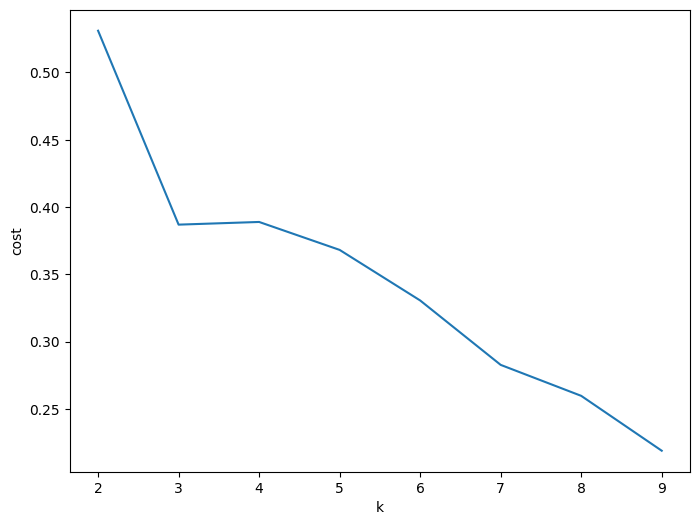

Text(0, 0.5, 'cost')

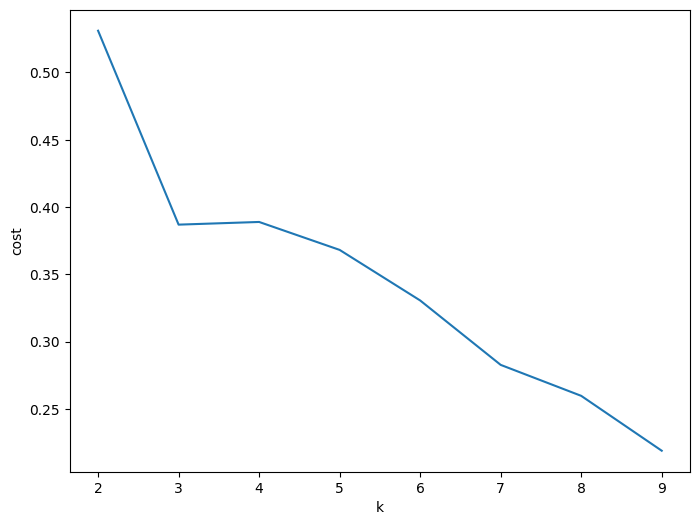

In [30]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [18]:
# Perform cluster sampling from the different clusters
sampling_ratio = 0.05  # Define the sampling ratio, e.g., 80% of the data
seed = 42  # Set a seed for reproducibility

# Get the cluster labels from the output DataFrame
cluster_labels = output.select("prediction").distinct().rdd.flatMap(lambda x: x).collect()

# Perform sampling from each cluster
sampled_data = None

for label in cluster_labels:
    # Filter the data based on the cluster label
    cluster_data = output.filter(col("prediction") == label)
    
    # Perform cluster sampling on the cluster data
    cluster_sample = cluster_data.sample(False, sampling_ratio, seed)
    
    # Union the sampled data with the previous clusters' sampled data
    if sampled_data is None:
        sampled_data = cluster_sample
    else:
        sampled_data = sampled_data.union(cluster_sample)

# Show the sampled data
sampled_data.show()


+-------------+--------------+--------------+----------------+----------------+----------------+----------------+------------------+-----------------+------------------+------------------+----------------+---------------+----------------+----------------+----------------+----------------+-------------------------+-------------------------+-------------------------+-------------------------+----------------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+----------+
|num_instances|num_attributes|dimensionality|num_numeric_attr|pct_numeric_attr|num_nominal_attr|pct_nominal_attr|avg_nominal_values|sd_nominal_values|min_nominal_values|max_nominal_values|avg_numeric_mean|sd_numeric_mean|min_numeric_mean|max_numeric_mean|missing_attr_cnt|missing_attr_pct|missing_instances_max_cnt|missing_instances_max_pct|missing_instances_min_cnt|missing_instances_min_pct|missing_instances_mean|missing_instances_mean_pct|datese

In [31]:
rows = sampled_data.count()
print(f"DataFrame Rows count : {rows}") 


DataFrame Rows count : 1252
DataFrame Rows count : 1252


In [32]:
filtered_data_1.dtypes

[('num_instances', 'double'),
 ('num_attributes', 'double'),
 ('dimensionality', 'double'),
 ('num_numeric_attr', 'double'),
 ('pct_numeric_attr', 'double'),
 ('num_nominal_attr', 'double'),
 ('pct_nominal_attr', 'double'),
 ('avg_nominal_values', 'double'),
 ('sd_nominal_values', 'double'),
 ('min_nominal_values', 'double'),
 ('max_nominal_values', 'double'),
 ('avg_numeric_mean', 'double'),
 ('sd_numeric_mean', 'double'),
 ('min_numeric_mean', 'double'),
 ('max_numeric_mean', 'double'),
 ('missing_attr_cnt', 'double'),
 ('missing_attr_pct', 'double'),
 ('missing_instances_max_cnt', 'double'),
 ('missing_instances_max_pct', 'double'),
 ('missing_instances_min_cnt', 'double'),
 ('missing_instances_min_pct', 'double'),
 ('missing_instances_mean', 'double'),
 ('missing_instances_mean_pct', 'double'),
 ('datesets_subject_main_match', 'int'),
 ('datesets_duplicates_match', 'int'),
 ('features', 'vector')]

[('num_instances', 'double'),
 ('num_attributes', 'double'),
 ('dimensionality', 'double'),
 ('num_numeric_attr', 'double'),
 ('pct_numeric_attr', 'double'),
 ('num_nominal_attr', 'double'),
 ('pct_nominal_attr', 'double'),
 ('avg_nominal_values', 'double'),
 ('sd_nominal_values', 'double'),
 ('min_nominal_values', 'double'),
 ('max_nominal_values', 'double'),
 ('avg_numeric_mean', 'double'),
 ('sd_numeric_mean', 'double'),
 ('min_numeric_mean', 'double'),
 ('max_numeric_mean', 'double'),
 ('missing_attr_cnt', 'double'),
 ('missing_attr_pct', 'double'),
 ('missing_instances_max_cnt', 'double'),
 ('missing_instances_max_pct', 'double'),
 ('missing_instances_min_cnt', 'double'),
 ('missing_instances_min_pct', 'double'),
 ('missing_instances_mean', 'double'),
 ('missing_instances_mean_pct', 'double'),
 ('datesets_subject_main_match', 'int'),
 ('datesets_duplicates_match', 'int'),
 ('features', 'vector')]

In [33]:
sampled_data.dtypes 

[('num_instances', 'double'),
 ('num_attributes', 'double'),
 ('dimensionality', 'double'),
 ('num_numeric_attr', 'double'),
 ('pct_numeric_attr', 'double'),
 ('num_nominal_attr', 'double'),
 ('pct_nominal_attr', 'double'),
 ('avg_nominal_values', 'double'),
 ('sd_nominal_values', 'double'),
 ('min_nominal_values', 'double'),
 ('max_nominal_values', 'double'),
 ('avg_numeric_mean', 'double'),
 ('sd_numeric_mean', 'double'),
 ('min_numeric_mean', 'double'),
 ('max_numeric_mean', 'double'),
 ('missing_attr_cnt', 'double'),
 ('missing_attr_pct', 'double'),
 ('missing_instances_max_cnt', 'double'),
 ('missing_instances_max_pct', 'double'),
 ('missing_instances_min_cnt', 'double'),
 ('missing_instances_min_pct', 'double'),
 ('missing_instances_mean', 'double'),
 ('missing_instances_mean_pct', 'double'),
 ('datesets_subject_main_match', 'int'),
 ('datesets_duplicates_match', 'int'),
 ('features', 'vector'),
 ('standardized', 'vector'),
 ('prediction', 'int')]

[('num_instances', 'double'),
 ('num_attributes', 'double'),
 ('dimensionality', 'double'),
 ('num_numeric_attr', 'double'),
 ('pct_numeric_attr', 'double'),
 ('num_nominal_attr', 'double'),
 ('pct_nominal_attr', 'double'),
 ('avg_nominal_values', 'double'),
 ('sd_nominal_values', 'double'),
 ('min_nominal_values', 'double'),
 ('max_nominal_values', 'double'),
 ('avg_numeric_mean', 'double'),
 ('sd_numeric_mean', 'double'),
 ('min_numeric_mean', 'double'),
 ('max_numeric_mean', 'double'),
 ('missing_attr_cnt', 'double'),
 ('missing_attr_pct', 'double'),
 ('missing_instances_max_cnt', 'double'),
 ('missing_instances_max_pct', 'double'),
 ('missing_instances_min_cnt', 'double'),
 ('missing_instances_min_pct', 'double'),
 ('missing_instances_mean', 'double'),
 ('missing_instances_mean_pct', 'double'),
 ('datesets_subject_main_match', 'int'),
 ('datesets_duplicates_match', 'int'),
 ('features', 'vector')]

In [34]:
sampled_data=sampled_data.drop("standardized","prediction")
sampled_data


num_instances,num_attributes,dimensionality,num_numeric_attr,pct_numeric_attr,num_nominal_attr,pct_nominal_attr,avg_nominal_values,sd_nominal_values,min_nominal_values,max_nominal_values,avg_numeric_mean,sd_numeric_mean,min_numeric_mean,max_numeric_mean,missing_attr_cnt,missing_attr_pct,missing_instances_max_cnt,missing_instances_max_pct,missing_instances_min_cnt,missing_instances_min_pct,missing_instances_mean,missing_instances_mean_pct,datesets_subject_main_match,datesets_duplicates_match,features
0.380531,0.555556,0.28254,1.0,1.0,0.944444,0.875,0.0689655,1.0,0.333333,0.857143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.380531,0.55555..."
0.541139,0.873684,0.942039,0.904255,0.242021,0.666667,0.957895,0.4,1.0,0.333333,0.5,0.964526,0.993476,1.0,0.997902,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.541139,0.87368..."
0.490506,0.7,0.847152,0.769231,0.230769,0.666667,0.9,0.4,1.0,0.333333,0.5,0.970013,0.99376,1.0,0.997074,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.490506,0.7,0.8..."
0.924348,0.25,0.943261,0.222222,0.0357143,0.333333,0.111111,0.1,1.0,0.0,0.25,0.993759,0.991619,1.0,0.99375,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.924348,0.25,0...."
0.942082,0.75,0.985521,0.777778,0.111111,0.666667,0.25,0.166667,1.0,0.25,0.0,0.978155,1.0,0.0,0.99375,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.942082,0.75,0...."
0.368,0.0769231,0.315333,0.888889,0.897436,0.75,0.729167,0.759036,0.936612,0.333333,0.84,0.912621,1.0,0.75,0.975,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.368,0.0769231,..."
0.192905,0.721311,0.654702,1.0,1.0,0.754098,0.117647,0.722635,0.702173,0.5,0.790984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.192905,0.72131..."
0.993011,0.294118,0.990098,0.222222,0.45098,0.7,0.575,0.275362,0.875078,0.333333,0.666667,0.811544,0.884586,0.666667,0.882526,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.993011,0.29411..."
0.827394,0.487179,0.663419,0.0,0.487179,0.575758,0.172727,0.181818,1.0,1.0,0.714286,0.857075,0.921663,0.0,0.916865,0.482759,0.00854706,0.92539,0.567742,0.988372,0.932633,0.985315,0.914919,0,0,"[0.827394,0.48717..."
0.956746,0.980545,0.550205,0.992157,0.596863,0.333333,0.98703,0.561521,0.593325,0.0,0.390625,0.999836,0.999882,1.0,0.999911,0.998095,0.902095,0.995327,0.891971,0.988636,0.999509,0.994245,0.866947,0,0,"[0.956746,0.98054..."


num_instances,num_attributes,dimensionality,num_numeric_attr,pct_numeric_attr,num_nominal_attr,pct_nominal_attr,avg_nominal_values,sd_nominal_values,min_nominal_values,max_nominal_values,avg_numeric_mean,sd_numeric_mean,min_numeric_mean,max_numeric_mean,missing_attr_cnt,missing_attr_pct,missing_instances_max_cnt,missing_instances_max_pct,missing_instances_min_cnt,missing_instances_min_pct,missing_instances_mean,missing_instances_mean_pct,datesets_subject_main_match,datesets_duplicates_match,features
0.380531,0.555556,0.28254,1.0,1.0,0.944444,0.875,0.0689655,1.0,0.333333,0.857143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.380531,0.55555..."
0.541139,0.873684,0.942039,0.904255,0.242021,0.666667,0.957895,0.4,1.0,0.333333,0.5,0.964526,0.993476,1.0,0.997902,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.541139,0.87368..."
0.490506,0.7,0.847152,0.769231,0.230769,0.666667,0.9,0.4,1.0,0.333333,0.5,0.970013,0.99376,1.0,0.997074,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.490506,0.7,0.8..."
0.924348,0.25,0.943261,0.222222,0.0357143,0.333333,0.111111,0.1,1.0,0.0,0.25,0.993759,0.991619,1.0,0.99375,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.924348,0.25,0...."
0.942082,0.75,0.985521,0.777778,0.111111,0.666667,0.25,0.166667,1.0,0.25,0.0,0.978155,1.0,0.0,0.99375,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.942082,0.75,0...."
0.368,0.0769231,0.315333,0.888889,0.897436,0.75,0.729167,0.759036,0.936612,0.333333,0.84,0.912621,1.0,0.75,0.975,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.368,0.0769231,..."
0.192905,0.721311,0.654702,1.0,1.0,0.754098,0.117647,0.722635,0.702173,0.5,0.790984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.192905,0.72131..."
0.993011,0.294118,0.990098,0.222222,0.45098,0.7,0.575,0.275362,0.875078,0.333333,0.666667,0.811544,0.884586,0.666667,0.882526,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,"[0.993011,0.29411..."
0.827394,0.487179,0.663419,0.0,0.487179,0.575758,0.172727,0.181818,1.0,1.0,0.714286,0.857075,0.921663,0.0,0.916865,0.482759,0.00854706,0.92539,0.567742,0.988372,0.932633,0.985315,0.914919,0,0,"[0.827394,0.48717..."
0.956746,0.980545,0.550205,0.992157,0.596863,0.333333,0.98703,0.561521,0.593325,0.0,0.390625,0.999836,0.999882,1.0,0.999911,0.998095,0.902095,0.995327,0.891971,0.988636,0.999509,0.994245,0.866947,0,0,"[0.956746,0.98054..."


In [35]:
result = sampled_data.union(filtered_data_1)

In [36]:

result.count()

1822

1822

## Modeling

In [37]:
# Define the layers for the neural network
layers = [len(numericCols), 5, 4, 2]
                         
# Define the parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(MultilayerPerceptronClassifier.maxIter, [100, 200]) \
    .addGrid(MultilayerPerceptronClassifier.blockSize, [128, 256]) \
    .build()

In [38]:
# Create a CrossValidator
crossval = CrossValidator(estimator=MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, labelCol="datesets_subject_main_match", featuresCol="features"),
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy", labelCol="datesets_subject_main_match"))

In [27]:
# Fit the model using the cross-validator
cv_model = crossval.fit(result)

# Get the best model from cross-validation
best_model = cv_model.bestModel

In [28]:

# Make predictions on the test data
predictions = best_model.transform(result)

## Evaluation

In [29]:
# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="datesets_subject_main_match", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
f1_score = evaluator.setMetricName("f1").evaluate(predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.2f}".format(f1_score* 100))
print("Precision: {:.2f}".format(precision* 100))
print("Recall: {:.2f}".format(recall* 100))

Accuracy: 81.83%
F1 Score: 80.22
Precision: 82.52
Recall: 81.83
